# Sea Surface Current Prediction using GRU

This notebook outlines the process of loading, inspecting, and preprocessing sea surface current data (`u` and `v` components) for training an GRU model. The goal is to predict sea surface currents for the next 24 hours based on historical data.

### Import Libraries

In [1]:
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import GRU, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import warnings
from sklearn.exceptions import DataConversionWarning

### Load and Inspect Data

The initial step involves loading the dataset using xarray, which facilitates working with multi-dimensional arrays, and inspecting its structure to understand the available dimensions, coordinates, and variables.

In [2]:
# Load your dataset
file_path = 'Data/Processed_SSC_Data.nc'
ds = xr.open_dataset(file_path)

# Print dataset structure
print("Dataset structure:")
print(ds, "\n")
print("="*175)

# Extract latitude and longitude values directly from the dataset
lats = ds['lat'].values
lons = ds['lon'].values

# Print the extracted latitude and longitude values
print("\nExtracted latitude values:")
print(lats, "\n")
print("\nExtracted longitude values:")
print(lons, "\n")
print("="*175)

start_time = ds['time'].values[0]
end_time = ds['time'].values[-1]

# Print the start and end times from the dataset
print("\nDataset start time:", start_time, "\n")
print("Dataset end time:", end_time, "\n")
print("="*175)

# Create a time range for the predictions
times = pd.date_range(start=start_time, end=end_time, freq='H')

# Print the created time range for predictions
print("\nTime range:")
print(times, "\n")
print("="*175)

Dataset structure:
<xarray.Dataset>
Dimensions:  (time: 168, lat: 52, lon: 43)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 ... 2023-01-07T23:00:00
  * lat      (lat) float32 35.74 35.77 35.79 35.81 ... 36.81 36.84 36.86 36.88
  * lon      (lon) float32 13.68 13.72 13.76 13.8 ... 15.26 15.3 15.34 15.38
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  MRAG (measured);LICA (measured);SOPU (...
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 19:17:47
    NC_GLOBAL.grid_type:               REGULAR
    NC

## Data Preprocessing

Prepare the data for GRU modeling, which involves several key steps:

1. Conversion to DataFrame: Convert the dataset to a pandas DataFrame for easier manipulation.
2. Handling NaN Values: Fill NaN values with the mean of each column.
3. Normalization: Scale the 'u' and 'v' features to a range between 0 and 1.
4. Sequence Creation: Generate input sequences for the GRU model.
5. Train-Test Split: Divide the data into training, validation, and testing sets.

In [3]:
# Convert dataset to DataFrame and reset index
df = ds.to_dataframe().reset_index()

print(f"DataFrame created with shape: {df.shape}")
print("="*175)

# Fill NaN values in 'u' and 'v' columns with their respective column means
df['u'] = df['u'].fillna(df['u'].mean())
df['v'] = df['v'].fillna(df['v'].mean())

# Initialize MinMaxScaler with range 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Select 'u' and 'v' columns for normalization
features = df[['u', 'v']]
features_scaled = scaler.fit_transform(features)

# Save the configured scaler to a file for future use
joblib.dump(scaler, 'Data/GRU/gru_scaler.save')

# Update 'u' and 'v' columns in DataFrame with scaled values
df[['u', 'v']] = features_scaled

# Specify input and target data for modeling
input_data = df[['u', 'v']] # Features for prediction
target_data = df[['u', 'v']] # Targets to predict

DataFrame created with shape: (375648, 10)


### Create Sequences for GRU

In [4]:
# Function to generate sequences for model training with corresponding target sequences
def create_sequences(input_data, target_data, sequence_length, prediction_length):
    X, y = [], []
    # Iterate through input_data to create sequences of specified length
    for i in range(len(input_data) - sequence_length - prediction_length + 1):
        # Append sequence of input_data to X
        X.append(input_data.iloc[i:i+sequence_length].values)
        # Append corresponding target sequence to y
        y.append(target_data.iloc[i+sequence_length:i+sequence_length+prediction_length].values)
    return np.array(X), np.array(y)

# Set parameters for creating sequences
sequence_length = 24  # Length of each input sequence (24 hours)
prediction_length = 24  # Length of each target sequence to predict (24 hours)

# Create sequences using defined parameters
X, y = create_sequences(input_data, target_data, sequence_length, prediction_length)

print(f"Sequences created. Input shape: {X.shape}, Target shape: {y.shape}\n")
print("="*175)

Sequences created. Input shape: (375601, 24, 2), Target shape: (375601, 24, 2)



###  Train-Test Split

In [5]:
# Split data into training set (70%) and temporary test set (30%) without shuffling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Further split temporary test set into validation and test sets, each being 15% of the original data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

print(f"Data split into training, validation, and testing sets. Training shape: {X_train.shape}, Validation shape: {X_val.shape}, Testing shape: {X_test.shape}\n")

# Check for NaNs or infinite values in the data
print(f"Training data contains NaN: {np.isnan(X_train).any() or np.isnan(y_train).any()}")
print(f"Validation data contains NaN: {np.isnan(X_val).any() or np.isnan(y_val).any()}\n")
print("="*175)

Data split into training, validation, and testing sets. Training shape: (262920, 24, 2), Validation shape: (56340, 24, 2), Testing shape: (56341, 24, 2)

Training data contains NaN: False
Validation data contains NaN: False



### Hyperparameters

In [6]:
# Hyperparameters for the GRU model
gru_units = 64  # Number of units in each GRU layer
dropout_rate = 0.3  # Dropout rate for regularization
dense_units = 50  # Number of units in the dense layer
output_units = 24 * 2  # Number of output units in the final layer (predicting 24 hours ahead for both 'u' and 'v')
activation_gru = 'tanh'  # Activation function for GRU layers
activation_dense = 'relu'  # Activation function for dense layer
input_shape = (24, 2)  # Shape of the input data (24 hours of data with 2 features each)
learning_rate = 0.001  # Learning rate for the optimizer
clipvalue = 1.0  # Gradient clipping value
loss_function = 'mean_squared_error'  # Loss function for model training
gru_model_path = 'Data/GRU/Saved_Models/gru_best_model.h5'  # Path to save the best GRU model
epochs= 100   # Number of epochs for model training
batch_size= 128   # Batch size for model training

### Define GRU Model Architecture

Define an GRU model architecture for our time series forecasting problem. The model will consist of a GRU layer followed by a Dense layer to predict the next 24 hours of `u` and `v` values based on the previous 24 hours.

In [7]:
# Initialize a Sequential model with a bidirectional GRU architecture
model = Sequential([
    Bidirectional(GRU(gru_units, activation=activation_gru, return_sequences=True, input_shape=input_shape)),
    Dropout(dropout_rate),
    Bidirectional(GRU(gru_units, activation=activation_gru)),
    Dropout(dropout_rate),
    Dense(dense_units, activation=activation_dense),
    Dropout(dropout_rate),
    Dense(output_units)  # Predicting 24 hours ahead for both 'u' and 'v'
])

# Build the model
model.build(input_shape=(None, *input_shape))

# Display the model's architecture summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 128)          26112     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0

### Optimizer

In [8]:
# Initialize the optimizer
optimizer = Adam(learning_rate=learning_rate, clipvalue=clipvalue)

### Compile the Model

Compiling the model with an appropriate optimizer and loss function. Since this is a regression problem (predicting continuous `u` and `v` values), we will use the Mean Squared Error (MSE) loss function. The Adam optimizer will be used for its efficiency in handling sparse gradients and adaptive learning rates.


In [9]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss_function)

### Train the Model

Training the model on the training set while validating its performance on the validation set. We will use a batch size of 64 and train for 50 epochs. Early stopping will be employed to halt training when the validation loss stops improving.

2055/2055 [==============================] - 152s 71ms/step - loss: 0.0100 - val_loss: 0.0031


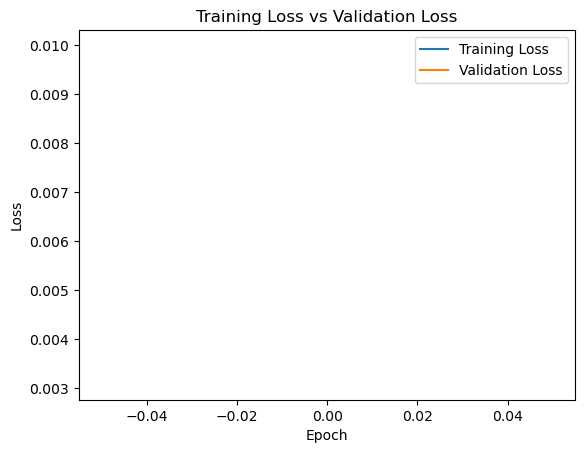

In [10]:
# Configure early stopping based on validation loss to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    mode='min',  
    min_delta=0.00001,
    verbose=1,  
    restore_best_weights=True  
)

# Configure model checkpointing to save the best model based on validation loss
model_checkpoint = ModelCheckpoint(
    gru_model_path,
    monitor='val_loss',  
    mode='min',  
    save_best_only=True,  
    verbose=0  
)

# Train the model with specified data, using early stopping and model checkpointing
history = model.fit(
    X_train, y_train.reshape(y_train.shape[0], -1),  
    epochs=epochs, batch_size=batch_size, 
    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)),  
    callbacks=[early_stopping, model_checkpoint]  
)

# Visualize training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')  
plt.plot(history.history['val_loss'], label='Validation Loss')  
plt.title('Training Loss vs Validation Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend()  
plt.show()  

### Evaluate the Model on Test Set

In [11]:
# Evaluate the model on the test set to determine the final loss value
test_loss = model.evaluate(X_test, y_test.reshape(y_test.shape[0], -1), verbose=0)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Reshape y_test and y_pred to calculate metrics
y_true = y_test.reshape(y_test.shape[0], -1)
y_pred = y_pred.reshape(y_pred.shape[0], -1)

# Calculate the different metrics
test_mse = mean_squared_error(y_true, y_pred)   # Lower is better. Range: [0, ∞), 0 being perfect.
test_mae = mean_absolute_error(y_true, y_pred)  # Lower is better. Range: [0, ∞), 0 being perfect.
test_rmse = np.sqrt(test_mse)                   # Lower is better. Range: [0, ∞), 0 being perfect.

# Print the metrics 
print(f'\nTest Loss (MSE): {test_loss}')
print(f'Test MAE: {test_mae}')
print(f'Test MSE: {test_mse}')
print(f'Test RMSE: {test_rmse}\n')
print("="*175)

1761/1761 [==============================] - 13s 6ms/step

Test Loss (MSE): 0.0032296604476869106
Test MAE: 0.030521792766042027
Test MSE: 0.003229673350866056
Test RMSE: 0.05683021512246857



# Making a Real Life Prediction

This section describes the process of making real-life predictions using a trained GRU model. We start by loading the model and input data, followed by making predictions for 'u' and 'v' sea surface currents.

Here we import the data that was saved on 2nd June 2023. We use this to make a prediction for 3rd June 2023. Then we compare the actual data from 3rd June to the predicted data for that day.

In [12]:
# Load previously trained model
model_path = load_model(gru_model_path)

# Open NetCDF file as input dataset
input_ds = xr.open_dataset('Data/GRU/sea_surface_currents_input_for_prediction.nc')

# Ignore warnings related to feature names in the input dataset
warnings.filterwarnings(action='ignore', category=UserWarning, message='.*X does not have valid feature names.*')
# Ignore warnings from sklearn about data conversion
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Retrieve scaler for data normalization from saved file
scaler = joblib.load('Data/GRU/gru_scaler.save')

# Compute global mean values for 'u' and 'v' variables as fallback for missing data
global_mean_u = np.nanmean(input_ds['u'].values)
global_mean_v = np.nanmean(input_ds['v'].values)

# Notification of prediction process initiation
print("Starting the prediction process...")

# Initialize placeholders for prediction outputs
predicted_u = np.zeros_like(input_ds['u'].values)
predicted_v = np.zeros_like(input_ds['v'].values)

# Loop through each spatial location for prediction
for lat_idx in range(len(input_ds['lat'])):
    for lon_idx in range(len(input_ds['lon'])):
        # Gather 24-hour historical data for 'u' and 'v' at current location
        u_history = input_ds['u'].isel(lat=lat_idx, lon=lon_idx).values[-24:]
        v_history = input_ds['v'].isel(lat=lat_idx, lon=lon_idx).values[-24:]
        
        # Use global means if historical data are entirely NaNs, else fill NaNs with local mean
        if np.all(np.isnan(u_history)):
            u_history = np.full(u_history.shape, global_mean_u)
        else:
            u_history[np.isnan(u_history)] = np.nanmean(u_history)
        
        if np.all(np.isnan(v_history)):
            v_history = np.full(v_history.shape, global_mean_v)
        else:
            v_history[np.isnan(v_history)] = np.nanmean(v_history)
        
        # Normalize historical data
        history_scaled = scaler.transform(np.stack([u_history, v_history], axis=1))
        
        # Prepare data for model input
        history_reshaped = history_scaled.reshape(1, 24, 2)
        
        # Predict future values
        prediction_scaled = model_path.predict(history_reshaped, verbose=0)
        
        # Convert predictions back to original scale
        prediction = scaler.inverse_transform(prediction_scaled.reshape(24, 2))
        
        # Save predictions to placeholders
        predicted_u[:, lat_idx, lon_idx] = prediction[:, 0]
        predicted_v[:, lat_idx, lon_idx] = prediction[:, 1]

# Construct xarray Dataset to hold predictions
predicted_ds = xr.Dataset(
    {
        "u": (("time", "lat", "lon"), predicted_u),
        "v": (("time", "lat", "lon"), predicted_v),
    },
    coords={
        "time": input_ds['time'].values[-24:], # Use last 24 hours of input time
        "lat": input_ds['lat'].values,
        "lon": input_ds['lon'].values,
    }
)

# Define path for saving predicted data
predicted_data_file_path = 'Data/GRU/gru_predicted_sea_surface_currents.nc'

# Write predictions to NetCDF file
predicted_ds.to_netcdf(predicted_data_file_path)

# Confirmation of successful prediction saving
print(f"\nPredictions saved to {predicted_data_file_path}\n")
print("="*175)

# Restore default warning behavior
warnings.filterwarnings(action='default', category=UserWarning, message='.*X does not have valid feature names.*')
warnings.filterwarnings(action='default', category=DataConversionWarning)

Starting the prediction process...

Predictions saved to Data/GRU/gru_predicted_sea_surface_currents.nc



# Compare Prediction to Actual Data

After generating predictions, proceed to compare these predictions against actual observed data to evaluate the model's performance.

In [13]:
# Open dataset to compare with predictions for evaluation
actual_data_file_path = 'Data/GRU/sea_surface_currents_compare_for_prediction.nc'
compare_ds = xr.open_dataset(actual_data_file_path)

# Extract and flatten actual 'u' and 'v' values for direct comparison
actual_u = compare_ds['u'].values.flatten()
actual_v = compare_ds['v'].values.flatten()

# Flatten predicted 'u' and 'v' values to match the format of actual values
predicted_u = predicted_ds['u'].values.flatten()
predicted_v = predicted_ds['v'].values.flatten()

# Remove NaN values from actual data and corresponding predictions for accurate error calculation
not_nan_mask_u = ~np.isnan(actual_u)
filtered_actual_u = actual_u[not_nan_mask_u]
filtered_predicted_u = predicted_u[not_nan_mask_u]

not_nan_mask_v = ~np.isnan(actual_v)
filtered_actual_v = actual_v[not_nan_mask_v]
filtered_predicted_v = predicted_v[not_nan_mask_v]

# Compute Mean Squared Error (MSE), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE) for 'u'
mse_u = mean_squared_error(filtered_actual_u, filtered_predicted_u)
mae_u = mean_absolute_error(filtered_actual_u, filtered_predicted_u)
rmse_u = np.sqrt(mse_u)

# Compute MSE, MAE, and RMSE for 'v' using filtered data
mse_v = mean_squared_error(filtered_actual_v, filtered_predicted_v)
mae_v = mean_absolute_error(filtered_actual_v, filtered_predicted_v)
rmse_v = np.sqrt(mse_v)

# Display error metrics for both 'u' and 'v'
print(f"Error Metrics for 'u':\nMSE: {mse_u}\nMAE: {mae_u}\nRMSE: {rmse_u}\n")
print(f"Error Metrics for 'v':\nMSE: {mse_v}\nMAE: {mae_v}\nRMSE: {rmse_v}\n")
print("="*175)

Error Metrics for 'u':
MSE: 0.03854182485596673
MAE: 0.15827557293958425
RMSE: 0.19632071937512538

Error Metrics for 'v':
MSE: 0.034090531096482794
MAE: 0.15227006746472505
RMSE: 0.18463621285241635



### Making comparisons for same location

In [14]:
# Define specific longitude and latitude for detailed comparison
selected_lon = 13.8
selected_lat = 35.81

# Display comparison of actual vs predicted 'u' values for the selected location over the first 24 hours
print(f"Filtered Actual vs Predicted 'u' values for the first 24 hours at location (lon: {selected_lon}, lat: {selected_lat}):")
for i in range(24):
    # Ensure there are enough filtered data points for comparison
    if i < len(filtered_actual_u) and i < len(filtered_predicted_u):
        print(f"Hour {i+1}: Actual u: {filtered_actual_u[i]}, Predicted u: {filtered_predicted_u[i]}")
    else:
        # Notify if filtered data points are insufficient for the full 24-hour comparison
        print(f"Hour {i+1}: Not enough data points available after filtering for NaN values.")

# Display comparison of actual vs predicted 'v' values for the same location and period
print(f"\nFiltered Actual vs Predicted 'v' values for the first 24 hours at location (lon: {selected_lon}, lat: {selected_lat}):")
for i in range(24):
    # Check for sufficient filtered data points
    if i < len(filtered_actual_v) and i < len(filtered_predicted_v):
        print(f"Hour {i+1}: Actual v: {filtered_actual_v[i]}, Predicted v: {filtered_predicted_v[i]}")
    else:
        # Indicate limited data availability after NaN filtering
        print(f"Hour {i+1}: Not enough data points available after filtering for NaN values.")

Filtered Actual vs Predicted 'u' values for the first 24 hours at location (lon: 13.8, lat: 35.81):
Hour 1: Actual u: -0.07104788967975725, Predicted u: 0.06831121444702148
Hour 2: Actual u: -0.04782448141978448, Predicted u: 0.075452521443367
Hour 3: Actual u: -0.014571334226734556, Predicted u: 0.08002528548240662
Hour 4: Actual u: 0.006820242418312718, Predicted u: 0.06548662483692169
Hour 5: Actual u: 0.009262624151131224, Predicted u: 0.06181376054883003
Hour 6: Actual u: 0.030540892678236085, Predicted u: 0.09131395816802979
Hour 7: Actual u: -0.07421332274404487, Predicted u: 0.0682186558842659
Hour 8: Actual u: -0.05912553329718562, Predicted u: 0.06977272033691406
Hour 9: Actual u: -0.036570216211938136, Predicted u: 0.07413985580205917
Hour 10: Actual u: -0.01091562718831708, Predicted u: 0.06437776237726212
Hour 11: Actual u: -0.010052023595182966, Predicted u: 0.05790102109313011
Hour 12: Actual u: 0.0011245187406154463, Predicted u: 0.07369930297136307
Hour 13: Actual u: -

### Visualisations

Ploting the first 24 values of the actual_u, actual_v, predicted_u, and predicted_v arrays.

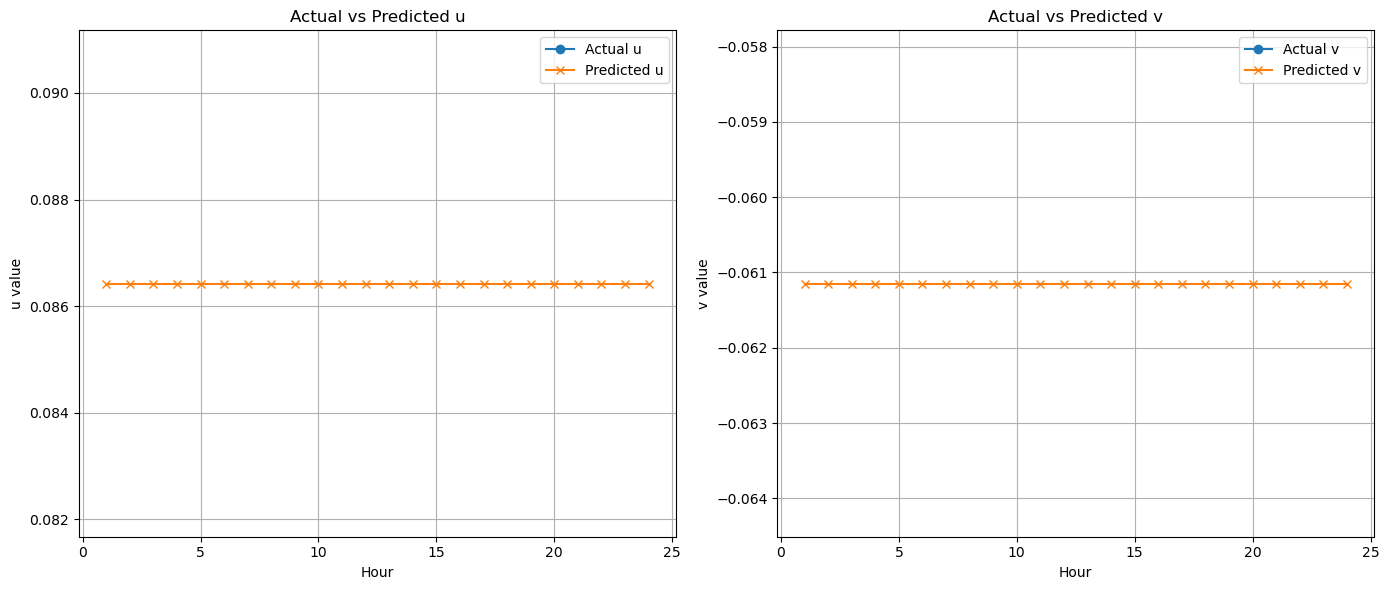

In [15]:
# Time array for x-axis (assuming 24 hours predictions)
time_hours = range(1, 25)

# Line plot for 'u'
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(time_hours, actual_u[:24], label='Actual u', marker='o')
plt.plot(time_hours, predicted_u[:24], label='Predicted u', marker='x')
plt.title('Actual vs Predicted u')
plt.xlabel('Hour')
plt.ylabel('u value')
plt.legend()
plt.grid(True)

# Line plot for 'v'
plt.subplot(1, 2, 2)
plt.plot(time_hours, actual_v[:24], label='Actual v', marker='o')
plt.plot(time_hours, predicted_v[:24], label='Predicted v', marker='x')
plt.title('Actual vs Predicted v')
plt.xlabel('Hour')
plt.ylabel('v value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()